# Processing GTEx and TCGA gene expression data for network analysis

Authors: Marouen Ben Guebila<sup>1</sup>, Deborah Weighill<sup>1</sup>

<sup>1</sup> Department of Biostatistics, Harvard T.H. Chan School of Public Health, Boston, MA.

## Introduction 
Gene expression is used as an input for several [network zoo](netzoo.github.io) GRN inference tools to inform about context-specific regulation. Gene expression data is used mainly to build the coexpression matrix input, therefore there are some essential considerations to be taken into acount for this specific task.

In this tutorial, we will go through the data processing pipeline of TCGA<sup>1</sup> gene expression provided by [Recount2](https://jhubiostatistics.shinyapps.io/recount/)<sup>2</sup>. The Recount project analyzed gene expression data from large project such as TCGA and GTEx<sup>3</sup> using a uniform pipeline, which makes it easier to control for variation due to the mapping method. Our analysis will consider the KIRC (Kidney Renal Clear Cell Carcinoma) subtype of the kidney cancer.

## 1. Load packages

In [ ]:
library('recount') # to process gene expression
library('limma') # to average replicates
library('DESeq2') # to do the mean-variance correction
library('vsn') # to visualize mean-variance plots

## 2. Data processing

First, we need to download the kidney cancer gene expression from the [recount2 project webpage](https://jhubiostatistics.shinyapps.io/recount/).

In [ ]:
load("/opt/data/netZooR/geneex/rse_gene_kidney.Rdata")

## 2.1. Filtering coding genes

The data comes as a RangeSummarizedExperiment (RSE) object. The "features" covered in [TCGA](https://portal.gdc.cancer.gov/) include genes but also transcripts in the broad sense of the term (pseudogenes, lncRNA, etc..). Therefore, we need to filter the coding genes.

In [ ]:
rowDataRse=rowData(rse_gene)
geneIds       = c()
geneSymbol    = c()
geneEntrezIds = c()
# First remove pseudogenes
usingEntrezGeneIDs=1
if(usingEntrezGeneIDs==1){
  for(i in 1:dim(rowDataRse)[1]){
    if(!is.na(rowDataRse$symbol[i][[1]][1])){
      geneIds       = c(geneIds,i)
      geneSymbol    = c(geneSymbol,rowDataRse$symbol[i][[1]][1])
      geneEntrezIds = c(geneEntrezIds, substr(rowDataRse$gene_id[i],1,15))
    }
  }
}

## 2.2. Filtering disease subtype

In addition, since we are interested in the KIRC subtype, we need to exclude the samples accounting for the other subytpes covered in the TCGA project such Kidney Chromophobe (KICH) and Kidney Renal Papillary Cell Carcinoma (KIRP).

In [ ]:
colDataRse=colData(rse_gene)
print(unique(colDataRse@listData$gdc_cases.project.name))

## 2.3. Filtering adjacent normal samples
Also, the TCGA project collected samples from various location in the tumor and around the tumor. Therefore, we need to remove the samples of normal tissue around the tumor referred to as "adjacent normal" tissue. In this case, the samples were called as "Solid Tissue Normal".

In [ ]:
print(unique(colDataRse@listData$gdc_cases.samples.sample_type))

In [ ]:
tumorIds=c()
patientSymbol=c()
for(i in 1:length(colDataRse@listData$gdc_cases.samples.sample_type)){
  if(colDataRse@listData$gdc_cases.samples.sample_type[i] %in% c("Primary Tumor","Additional - New Primary") && colDataRse@listData$gdc_cases.project.name[i] == "Kidney Renal Clear Cell Carcinoma"){
    tumorIds = c(tumorIds,i)     
    patientSymbol = c(patientSymbol, colDataRse@listData$gdc_cases.samples.portions.analytes.aliquots.submitter_id[i])
  }
}
#check that samples are LUAD and not normal
colDataRse@listData$gdc_cases.project.name[tumorIds]
colDataRse@listData$gdc_cases.samples.sample_type[tumorIds]

We can also use the sample barcode id, which is a more convenient way of filtering out the control and adjacent normal samples. According to the [barcode documentation](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/) of the TCGA project, sample id encodes tumor types from 01 - 09, normal types from 10 - 19 and control samples from 20 - 29. 
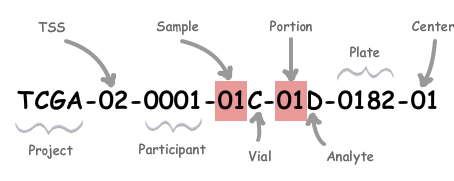

Therefore, by extracting the sample id from TCGA patient id, we can filter out the samples that aren't in the 01-09 interval.

In [ ]:
tumorIds=c()
patientSymbol=c()
for(i in 1:length(colDataRse@listData$gdc_cases.samples.sample_type)){
    sampleCodeStr = strsplit(colDataRse@listData$gdc_cases.samples.portions.analytes.aliquots.submitter_id[i],'-')[[1]][4]
    sampleCodeNum = as.numeric(substr(sampleCodeStr,1,2))
    if(sampleCodeNum>=1 && sampleCodeNum<=9 && colDataRse@listData$gdc_cases.project.name[i] == "Kidney Renal Clear Cell Carcinoma"){
        tumorIds = c(tumorIds,i)     
        patientSymbol = c(patientSymbol, colDataRse@listData$gdc_cases.samples.portions.analytes.aliquots.submitter_id[i])
    }
}
#check that samples are LUAD and not normal
length(colDataRse@listData$gdc_cases.project.name[tumorIds])
length(colDataRse@listData$gdc_cases.samples.sample_type[tumorIds])

Finally, after collecting the indices for tumor subytpe samples and coding genes, we can filter our RSE object which now contains 25526 genes and 544 KIRC samples.

In [ ]:
rse_gene=rse_gene[geneIds,tumorIds]
rse_gene

## 2.4. Filter low counts
We also need to filter genes that have low counts across all samples. This will remove any irrelevant genes for our analysis but also will speed up the network inference tool. Here, we filtered the 23 genes that had a maximum of 1 count across all samples but larger thresholds can be considered as well. The final number of retained genes in now 25503 genes.

In [ ]:
countMat=SummarizedExperiment::assay(rse_gene, 1)

In [ ]:
length(which(rowSums(countMat) <= 1))
indFilter = which(rowSums(countMat) <= 1)

In [ ]:
rse_gene=rse_gene[-indFilter,]

In [ ]:
rse_gene

## 2.5. Normalize between-sample counts using DESeq2
Now that we have a filtered count matrix, perhaps the most imporant step is deciding on the normalization method. There are two families of normalizations: between-sample normalization and within-sample normalization. Within-sample normalization is useful to quantify gene expression and compare the expression of genes within the sample sample. To do so, we need to take into account gene length and total number of mapped reads which are corrected for by scaling the counts by the total reads number, computing RPKM<sup>4</sup> or TPM<sup>5</sup>.

However, when we are interested in making inference about gene expression between samples or groups of samples such as in a case versus control setting, we need between-sample normalization mehtods. This is usually the case for differential gene expression analysis, clustering, and visualization.

For our specific case, we are using gene expression to build a coexpression matrix that we will use as an input to [netzoo](netzoo.github.io) tools. Intuitively, since we are computing the correlation between two genes across several samples, we need to normalize between samples. In other words, the features of the genes such length and proportion of reads coverd do not have an effect since they are the same across all samples. We can see this more clearly when we consider the following formula for the Pearson Correlation Coefficient (PCC):

\begin{equation}
r = \frac{Z_{X}Z_{Y}}{n}
\end{equation}

, where $X$ and $Y$ are two gene expression vectors across $n$ samples, $Z_{X}$ and $Z_{Y}$ are z-scored $X$ and $Y$, and $r$ is the PCC between $X$ and $Y$. We see that, owing to the definition of a z-score, we need to be able to do between-sample comparisons rather than within-sample.

We will use the Variance Stabilisation Transform (VST)<sup>6</sup> method to do between-sample normalization. This method is available through the DESeq2<sup>7</sup> package. VST allows to reduce the dependence between the mean and the variance for gene expression data. By ensuring the homoscedasticity of the gene expression samples, VST reduces the sample-induced variance and allows to compare the samples between them. Other methods such as rlog<sup>7</sup>, and edgeR's TMM<sup>8</sup> allow to correct for sample-specific variance and qsmooth<sup>9</sup> which is particularly interesting for correcting between-sample variation but keeping the between-group differences in a case versus control setting.

In [ ]:
countMat=SummarizedExperiment::assay(rse_gene, 1)
vsd <- vst(countMat, blind=FALSE)
meanSdPlot(vsd)

## 2.6. Average isoforms
Finally, there could be transcript isoforms coding for the same gene. The simplest way to address this question would be to average them.

In [ ]:
colnames(vsd)=patientSymbol
rownames(vsd)=geneSymbol[-indFilter]

In [ ]:
vsd=avearrays(t(vsd))
vsd=as.data.frame(t(vsd))

In [ ]:
vsd

# 3. Processing GTEx data

We could be interested in doing a comparative analysis of cancer kidney tissue and normal kidney using both TCGA and GTEX. Since Recount uniformly processed gene expression in these dataset, the variability due to alignemnt methods is reduced considerbaly.

Therefore, we process the normal kidney gene expression data from GTEx following the same pipeline

In [ ]:
load("rse_gene_kidney_gtex.Rdata")

Only keep protein-coding genes

In [ ]:
rowDataRse=rowData(rse_gene)
geneIds       = c()
geneSymbol    = c()
geneEntrezIds = c()
# First remove pseudogenes
usingEntrezGeneIDs=1
if(usingEntrezGeneIDs==1){
  for(i in 1:dim(rowDataRse)[1]){
    if(!is.na(rowDataRse$symbol[i][[1]][1])){
      geneIds       = c(geneIds,i)
      geneSymbol    = c(geneSymbol,rowDataRse$symbol[i][[1]][1])
      geneEntrezIds = c(geneEntrezIds, substr(rowDataRse$gene_id[i],1,15))
    }
  }
}

In [ ]:
rse_gene=rse_gene[geneIds,]
rse_gene

Filtering low counts

In [ ]:
countMat=SummarizedExperiment::assay(rse_gene, 1)
length(which(rowSums(countMat) <= 1))
indFilter = which(rowSums(countMat) <= 1)
rse_gene=rse_gene[-indFilter,]
rse_gene

Normalize using vsd

In [ ]:
countMat=SummarizedExperiment::assay(rse_gene, 1)
vsd <- vst(countMat, blind=FALSE)
meanSdPlot(vsd)

Then, average isoforms

In [ ]:
rownames(vsd)=geneSymbol[-indFilter]

In [ ]:
vsd=avearrays(t(vsd))
vsd=as.data.frame(t(vsd))
vsd

## References

1- Gao, Galen F., et al. "Before and after: comparison of legacy and harmonized TCGA genomic data commons’ data." Cell systems 9.1 (2019): 24-34.

2- Collado-Torres, Leonardo, et al. "Reproducible RNA-seq analysis using recount2." Nature biotechnology 35.4 (2017): 319-321.

3- GTEx Consortium. "The GTEx Consortium atlas of genetic regulatory effects across human tissues." Science 369.6509 (2020): 1318-1330.

4- Mortazavi, Ali, et al. "Mapping and quantifying mammalian transcriptomes by RNA-Seq." Nature methods 5.7 (2008): 621-628.

5- Li, Bo, et al. "RNA-Seq gene expression estimation with read mapping uncertainty." Bioinformatics 26.4 (2010): 493-500.

6- Love, Michael I., Wolfgang Huber, and Simon Anders. "Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2." Genome biology 15.12 (2014): 1-21.

7- Anders, Simon, and Wolfgang Huber. "Differential expression analysis for sequence count data." Nature Precedings (2010): 1-1.

8- Robinson, Mark D., Davis J. McCarthy, and Gordon K. Smyth. "edgeR: a Bioconductor package for differential expression analysis of digital gene expression data." Bioinformatics 26.1 (2010): 139-140.

9- Hicks, Stephanie C., et al. "Smooth quantile normalization." Biostatistics 19.2 (2018): 185-198.